In [1]:
using Ai4EComponentLib
using Ai4EComponentLib.CompressedAirSystem
using ModelingToolkit, DifferentialEquations
using Plots

In [2]:
stateEquation(p, ρ, T) = p - ρ * T * 287.11
@register_symbolic stateEquation(p, ρ, T) #状态方程

@connector function FlowPort2(; name, T=330)
    sts = @variables begin
        p(t) = 1.013e5
        T(t) = T
        (qm(t)=0, [connect = Flow])
        (ρ(t)=12, [connect = Stream])
        (μ(t)=1.819e-1, [connect = Stream])
        (qv(t)=0, [connect = Stream])
    end
    eqs = [
        0 ~ stateEquation(p, ρ, T)
        μ ~ 1.819e-1
        qv ~ qm / ρ
    ]
    ODESystem(eqs, t, sts, []; name=name)
end

FlowPort2 (generic function with 1 method)

In [14]:
function TransitionPipe2(; name, n=10, f=0.011, D=1.0, L=1.0, T=300, p0= 1e5 * ones(n), qm0=zeros(n))

    RT = 287.11 * T
    A0 = pi / 4 * D^2
    c10 = RT / A0
    c20 = c10 * f / 2 / D

    @named inlet = FlowPort2()
    @named outlet = FlowPort2()

    @parameters begin
        A = A0
        c1 = c10
        c2 = c20
        dx = L / n
        f = f

        U = 1.68
    end
    

    @variables (qm(t))[1:n] (p(t))[1:n+1] (tm(t))[1:n+1]

    initialValue = Dict(qm[i] => qm0[i] for i = 1:n)
    merge!(initialValue, Dict(p[i] => p0[i] for i = 1:n))
    merge!(initialValue, Dict(tm[i] => 330 for i = 1:n))

    eqs_continous = [
        ∂(p[i]) ~ c1 * (qm[i-1] - qm[i]) / dx
        for i = 2:n
    ]
    
    eqs_continous_tm = [
        tm[i] ~ U * A * (tm[i - 1] - T)
        for i = 2:n
    ]

    eqs_continous_tm2 = [
        # ∂(tm[i]) ~ tm[i] - T
        # for i = 2:n
    ]

    eqs_momentum = [
        ∂(qm[i]) ~ (c1 * qm[i]^2 / (0.5 * (p[i+1] + p[i]))^2 - A) * (p[i+1] - p[i]) / dx + c1 * qm[i] / (0.5 * (p[i+1] + p[i])) * (qm[i-1] - qm[i+1]) / dx - c2 * qm[i] * abs(qm[i]) / (0.5 * (p[i+1] + p[i]))
        for i = 2:n-1
    ]

    bd = [
        tm[1] ~ inlet.T
        tm[n+1] ~ outlet.T
        p[1] ~ inlet.p
        p[n+1] ~ outlet.p
        qm[n] ~ -outlet.qm
        qm[1] ~ inlet.qm
        ∂(qm[1]) ~ (c1 * qm[1]^2 / (0.5 * (p[2] + p[1]))^2 - A) * (p[2] - p[1]) / dx + c1 * qm[1] / (0.5 * (p[2] + p[1])) * (3 * qm[1] - 4 * qm[2] + qm[3]) / dx - c2 * qm[1] * abs(qm[1]) / (0.5 * (p[2] + p[1]))
        ∂(qm[n]) ~ (c1 * qm[n]^2 / (0.5 * (p[n+1] + p[n]))^2 - A) * (p[n+1] - p[n]) / dx + c1 * qm[n] / (0.5 * (p[n+1] + p[n])) * (-3 * qm[n] + 4 * qm[n-1] - qm[n-2]) / dx - c2 * qm[n] * abs(qm[n]) / (0.5 * (p[n+1] + p[n]))
    ]
    compose(ODESystem([eqs_continous; eqs_momentum; bd; eqs_continous_tm; eqs_continous_tm2], t; name=name, defaults=initialValue), inlet, outlet)
end

TransitionPipe2 (generic function with 1 method)

In [25]:
f=0.05                  # Friction resistance coefficient
n2 = 40                 # Number of nodes
D2 = 0.4                # Pipe diameter
L2 = 200                # length
R2 = 3000               # Resistance coefficient
T2 = 300                # Temperature
qm02 = 10 * ones(n2)    # Initial mass flow rate
p02 = range(10e5,8e5,length=n2)  #initial pressure

@named transPipe = TransitionPipe2(n=n2, D=D2, L=L2, T=T2, p0=p02, qm0=qm02, f=f)
# @named transPipe2 = TransitionPipe2(n=n2, D=D2, L=L2, T=T2, p0=p02, qm0=qm02, f=f)
# @named transPipe3 = TransitionPipe2(n=n2, D=D2, L=L2, T=T2, p0=p02, qm0=qm02, f=f)

inletBoundary = Dict(
    "p" => 5.0e5,
    "T" => 300,
)

outletBoundary = Dict(
    "T" => 300,
    "p" => 4e5,
)

@named inletSource = Source(boundary=inletBoundary)
@named outletSource = Source(boundary=outletBoundary)

┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: outlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40


┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: outlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/.julia/packages/ModelingToolkit/hBVcX/src/systems/connectors.jl:40
┌ Warning: source contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit /Users/jerell/

Model outletSource with 5 (6) equations
States (6):
  source₊T(t) [defaults to 300]
  source₊p(t) [defaults to 101300.0]
  source₊qm(t) [defaults to 0]
  source₊ρ(t) [defaults to 1.2]
⋮
Parameters (0):

In [26]:
eqs = [
    connect(transPipe.inlet, inletSource.source),
    # connect(transPipe.outlet, transPipe2.inlet),
    # connect(transPipe2.outlet, transPipe3.inlet),
    connect(transPipe.outlet, outletSource.source)
]

3-element Vector{Equation}:
 connect(transPipe.inlet, inletSource.source)
 connect(transPipe.outlet, transPipe2.inlet)
 connect(transPipe2.outlet, outletSource.source)

In [27]:
@named eq_model = ODESystem(eqs, t)
@named model = compose(
    eq_model,
    inletSource, outletSource,
    transPipe, #transPipe2, transPipe3
)

sys = structural_simplify(model)
prob = ODEProblem(sys, [], (0, 3))

ModelingToolkit.ExtraVariablesSystemException: ExtraVariablesSystemException: The system is unbalanced. There are 152 highest order derivative variables and 149 equations.
More variables than equations, here are the potential extra variable(s):
 (transPipe₊p(t))[2]
 (transPipe₊p(t))[3]
 (transPipe₊p(t))[4]
 (transPipe₊p(t))[5]
 (transPipe₊p(t))[6]
 (transPipe₊p(t))[7]
 (transPipe₊p(t))[8]
 (transPipe₊p(t))[9]
 (transPipe₊p(t))[10]
 (transPipe₊p(t))[11]
 (transPipe₊p(t))[12]
 (transPipe₊p(t))[13]
 (transPipe₊p(t))[14]
 (transPipe₊p(t))[15]
 (transPipe₊p(t))[16]
 (transPipe₊p(t))[17]
 (transPipe₊p(t))[18]
 (transPipe₊p(t))[19]
 (transPipe₊p(t))[20]
 (transPipe₊p(t))[21]
 (transPipe₊p(t))[22]
 (transPipe₊p(t))[23]
 (transPipe₊p(t))[24]
 (transPipe₊p(t))[25]
 (transPipe₊p(t))[26]
 (transPipe₊p(t))[27]
 (transPipe₊p(t))[28]
 (transPipe₊p(t))[29]
 (transPipe₊p(t))[30]
 (transPipe₊p(t))[31]
 (transPipe₊p(t))[32]
 (transPipe₊p(t))[33]
 (transPipe₊p(t))[34]
 (transPipe₊p(t))[35]
 (transPipe₊p(t))[36]
 (transPipe₊p(t))[37]
 (transPipe₊p(t))[38]
 (transPipe₊p(t))[39]
 (transPipe₊p(t))[40]
 (transPipe₊qm(t))[2]
 (transPipe₊qm(t))[3]
 (transPipe₊qm(t))[4]
 (transPipe₊qm(t))[5]
 (transPipe₊qm(t))[6]
 (transPipe₊qm(t))[7]
 (transPipe₊qm(t))[8]
 (transPipe₊qm(t))[9]
 (transPipe₊qm(t))[10]
 (transPipe₊qm(t))[11]
 (transPipe₊qm(t))[12]
 (transPipe₊qm(t))[13]
 (transPipe₊qm(t))[14]
 (transPipe₊qm(t))[15]
 (transPipe₊qm(t))[16]
 (transPipe₊qm(t))[17]
 (transPipe₊qm(t))[18]
 (transPipe₊qm(t))[19]
 (transPipe₊qm(t))[20]
 (transPipe₊qm(t))[21]
 (transPipe₊qm(t))[22]
 (transPipe₊qm(t))[23]
 (transPipe₊qm(t))[24]
 (transPipe₊qm(t))[25]
 (transPipe₊qm(t))[26]
 (transPipe₊qm(t))[27]
 (transPipe₊qm(t))[28]
 (transPipe₊qm(t))[29]
 (transPipe₊qm(t))[30]
 (transPipe₊qm(t))[31]
 (transPipe₊qm(t))[32]
 (transPipe₊qm(t))[33]
 (transPipe₊qm(t))[34]
 (transPipe₊qm(t))[35]
 (transPipe₊qm(t))[36]
 (transPipe₊qm(t))[37]
 (transPipe₊qm(t))[38]
 (transPipe₊qm(t))[39]
 (transPipe₊qm(t))[1]
 (transPipe₊qm(t))[40]
 outletSource₊source₊qv(t)
 transPipe₊outlet₊qv(t)
 transPipe2₊inlet₊p(t)

In [28]:
sol = solve(prob, Rodas4())

retcode: Success
Interpolation: specialized 3rd order "free" stiffness-aware interpolation
t: 82-element Vector{Float64}:
 0.0
 1.0e-6
 1.1e-5
 0.00011099999999999999
 0.0007548421007522971
 0.0017946459964718463
 0.0028344498921913956
 0.0044346390039549915
 0.006184627309288136
 0.008383709875646364
 ⋮
 2.0841015579270947
 2.183603717055967
 2.297282883765205
 2.415193848008967
 2.5405861095687268
 2.6729375037145053
 2.8176747300922598
 2.9836600206682373
 3.0
u: 82-element Vector{Vector{Float64}}:
 [994871.7948717949, 989743.5897435897, 984615.3846153846, 979487.1794871795, 974358.9743589744, 969230.7692307692, 964102.5641025641, 958974.358974359, 953846.1538461539, 948717.9487179487  …  10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 5.804976025449015, 4.643980820359213, 5.804976025449015, 4.643980820359212]
 [994871.7940112037, 989743.5897435909, 984615.3846153861, 979487.179487181, 974358.974358976, 969230.7692307709, 964102.5641025658, 958974.3589743606, 953846.1538461555, 948717.948717950

In [29]:
sol[transPipe.tm]

82-element Vector{Vector{Float64}}:
 [300.0, 0.0, -63.33450789637023, -76.70537419795484, -79.52816498915158, -80.12409854133442, -80.24990906888921, -80.27646956172542, -80.28207688086964, -80.28326067019836  …  -80.2835774663393, -80.2835774663393, -80.2835774663393, -80.2835774663393, -80.2835774663393, -80.2835774663393, -80.2835774663393, -80.2835774663393, -80.2835774663393, 300.0]
 [300.0, 0.0, -63.33450789637023, -76.70537419795484, -79.52816498915158, -80.12409854133442, -80.24990906888921, -80.27646956172542, -80.28207688086964, -80.28326067019836  …  -80.2835774663393, -80.2835774663393, -80.2835774663393, -80.2835774663393, -80.2835774663393, -80.2835774663393, -80.2835774663393, -80.2835774663393, -80.2835774663393, 300.0]
 [300.0, 0.0, -63.33450789637023, -76.70537419795484, -79.52816498915158, -80.12409854133442, -80.24990906888921, -80.27646956172542, -80.28207688086964, -80.28326067019836  …  -80.2835774663393, -80.2835774663393, -80.2835774663393, -80.2835774663393, -

┌ Info: Saved animation to /Users/jerell/Repos/jigsaw/engine/anim_p_fps30.gif
└ @ Plots /Users/jerell/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/Users/jerell/Repos/jigsaw/engine/anim_p_fps30.gif")
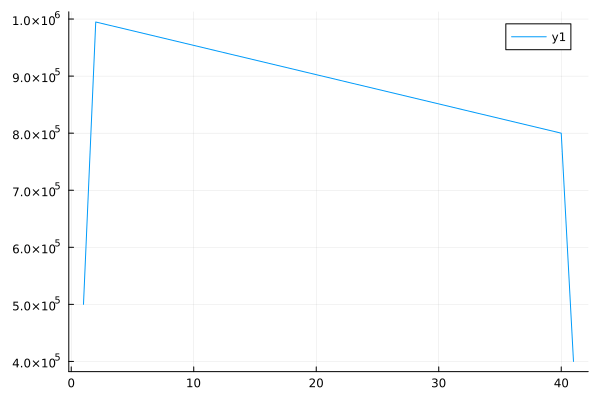

In [30]:
anim = @animate for i ∈ sol[transPipe.p]
    plot(i)
end
gif(anim, "anim_p_fps30.gif", fps = 30)

┌ Info: Saved animation to /Users/jerell/Repos/jigsaw/engine/anim_qm_fps30.gif
└ @ Plots /Users/jerell/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/Users/jerell/Repos/jigsaw/engine/anim_qm_fps30.gif")
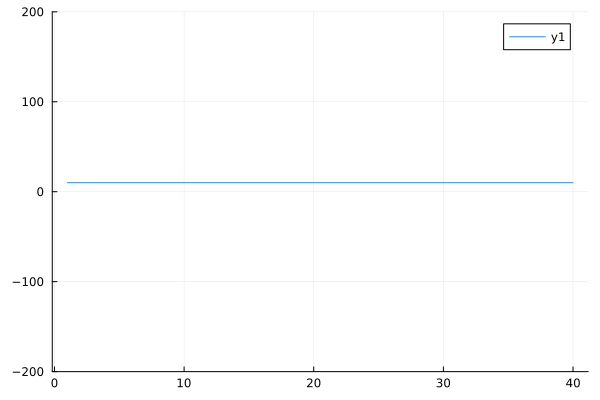

In [31]:
anim = @animate for i ∈ sol[transPipe.qm]
    plot(i, ylim=(-200, 200))
end
gif(anim, "anim_qm_fps30.gif", fps = 30)


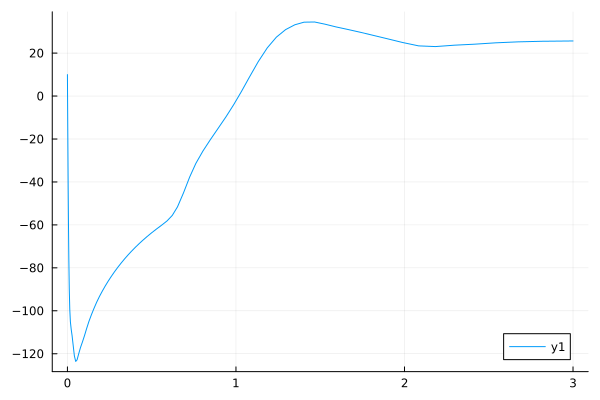

In [32]:
plot(sol.t, map(x -> x[1] ,sol[transPipe.qm]))

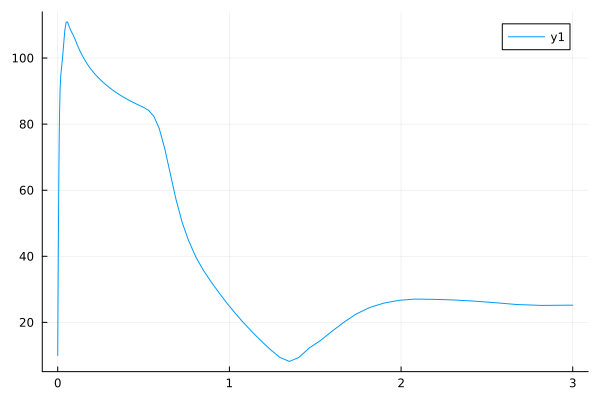

In [33]:
plot(sol.t, map(x -> x[40] ,sol[transPipe.qm]))

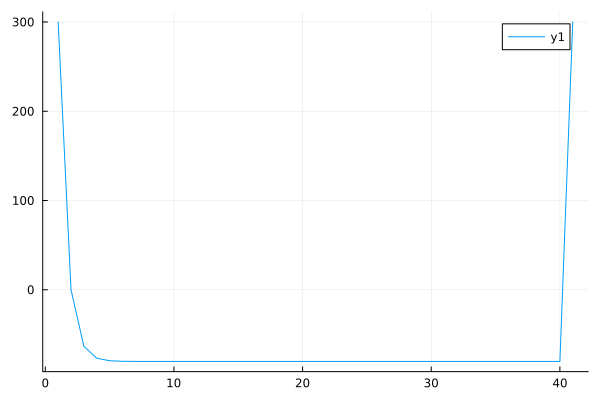

In [36]:
plot(sol[transPipe.tm][1])